## Modelling  

In [12]:
## importing necessary libaries

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


import keras
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics


## Read Data

#### Loding data from csv which we converted in EDA notebook. 
Renaming our label column from "default payment next month" to Is_default and convert it into a category 
where Is_default 1 means the customer defaults or yes, and 0 means no or customer did not default.

We could also drop unwanted column which does not add any meaning in our data like ID (which is just a bunch of number).

In [13]:
def load_original_dataframe():
    default =pd.read_csv("/Users/shikhagautam/Documents/IOD/default of credit card clients.csv")
    default.rename(columns={'default payment next month':'is_default'},inplace=True)
    default["is_default"] = default["is_default"].astype('category')
    unwanted_columns=['ID','Unnamed: 0']
    for col in unwanted_columns:
        default.pop(col)
    
    return default

### Data cleaning and pre-processing

Dividing data columns into categorical and numerical features columns. 

As in marriage and education there are some unknown values. 


In [14]:
 load_original_dataframe().MARRIAGE.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [15]:
load_original_dataframe().EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

### Unknown value 

In MARRIAGE column is 0 is unknown where 1=married, 2=single, 3=others and in 

EDUCATION 1=graduate school, 2=university, 3=high school, 4=others, 0,5 and 6 are unknown.

So decided to drop those rows with unknown values of Marriage and eductaion.

## Scaling the features
As some of the columns are not on the same scale like some contains -1,1 kind of values where 
others contains values in 1000s.

### One hot- encoding
Doing one hot encoding on a categorical features which is given below. 

In [16]:
def load_dataframe_and_features():
    categorical_feature_names = ['SEX', 'MARRIAGE','EDUCATION']
    numeric_feature_names = ['AGE','LIMIT_BAL'
                         ,'PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6'
                         ,'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'
                         ,'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6'
                        ]
    
    #step 1
    default=load_original_dataframe()
    
    #step 2
    #remove unknown categories
    default = default.drop(default[default['MARRIAGE']==0].index)
    default = default.drop(default[default['EDUCATION']==0].index)
    default = default.drop(default[default['EDUCATION']==5].index)
    default = default.drop(default[default['EDUCATION']==6].index)
    
    #step 3
    scaler = StandardScaler()
    #Standardizing columns as columns are not on same scale
    #for example pay1 contains value -1,1,2 and bill amount has values in 12,000
    for col in numeric_feature_names:
        default[col] = scaler.fit_transform(default[col].values.reshape(-1, 1))
        
    #step 4
    # one-hot encoding
    default=pd.get_dummies(default, columns=categorical_feature_names, drop_first=True)

    default.rename(columns={'SEX_2':'is_female',
                        'MARRIAGE_2':'is_marr_single',
                        'MARRIAGE_3':'is_marr_others',
                        'EDUCATION_2':'is_edu_university',
                        'EDUCATION_3':'is_edu_highschool',
                        'EDUCATION_4':'is_edu_others'
                       },inplace=True)
    return default

In [17]:
default=load_dataframe_and_features()
#new features
categorical_feature_names = ['is_marr_single','is_marr_others'
                            ,'is_edu_university','is_edu_highschool'
                            ,'is_edu_others']
numeric_feature_names = ['AGE','LIMIT_BAL'
                         ,'PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6'
                         ,'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'
                         ,'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6'
                        ]
default.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,is_default,is_female,is_marr_single,is_marr_others,is_edu_university,is_edu_highschool,is_edu_others
0,-1.135512,-1.244325,1.791873,1.776654,-0.697265,-0.666863,-1.527923,-1.486255,-0.641203,-0.646339,...,-0.307347,-0.314553,-0.293444,1,1,0,0,1,0,0
1,-0.365937,-1.027242,-0.876018,1.776654,0.136226,0.186234,0.232334,1.985406,-0.657981,-0.665755,...,-0.243696,-0.314553,-0.180174,1,1,1,0,1,0,0
2,-0.596810,-0.158912,0.013279,0.109462,0.136226,0.186234,0.232334,0.249576,-0.296016,-0.492299,...,-0.243696,-0.248953,-0.010269,0,1,1,0,1,0,0
3,-0.904640,0.166712,0.013279,0.109462,0.136226,0.186234,0.232334,0.249576,-0.054075,-0.009999,...,-0.237331,-0.244427,-0.236809,0,1,0,0,1,0,0
4,-0.904640,2.337536,-0.876018,0.109462,-0.697265,0.186234,0.232334,0.249576,-0.577089,-0.610131,...,0.265508,-0.269355,-0.254989,0,0,0,0,1,0,0


## New dataframe with all the scaler values.

### Train-Test Split

In [18]:
features=categorical_feature_names+numeric_feature_names
X = default[features]
y = default['is_default']

seed = 42
test_size = 0.20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

### SMOTE (Synthetic Minority Oversampling Technique)




##### 

As from the EDA we know that our data is unbalanced by showing 78-22 ratio in which 78% non defaulters and 22% defaulters customers. So for balancing our data we will use SMOTE here. Because our purpose for this is to identify the minority class which is 22% so that we can do better prediction on customer that who is going to default which can benefit the  respective bank.




In [19]:
#!pip install imblearn
#!pip install threadpoolctl==3.1.0

In [20]:
oversampled = SMOTE(random_state=0)

X_train_smote,y_train_smote = oversampled.fit_resample(X_train, y_train)
y_train_smote.value_counts()

0    18405
1    18405
Name: is_default, dtype: int64

So we have done oversampling for our minority class and our data is balanced. We now using sample to fit our estimators. 

### 1.Random Forest

In [42]:
grid_param = {
    'n_estimators': [500]
}

In [43]:
#class_weight 0= (100/(2*78)) and 1= (100/(2*22))
randomforest_estimator=RandomForestClassifier(random_state=42)

cv_rf = GridSearchCV(estimator=randomforest_estimator, 
                     param_grid=grid_param, 
                     cv= 3)
cv_rf.fit(X_train_smote,y_train_smote)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'n_estimators': [500]})

In [45]:
def evaluate_report(y_actual,y_pred):
    predictions = [round(value) for value in y_pred ]
    # evaluate predictions
    accuracy = accuracy_score(y_actual, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print(classification_report(y_actual, y_pred ))

In [46]:
print(cv_rf.best_params_)
randomforest_estimator = cv_rf.best_estimator_
randomforest_estimator.fit(X_train_smote, y_train_smote)

{'n_estimators': 500}


RandomForestClassifier(n_estimators=500, random_state=42)

In [47]:
y_pred_rf = randomforest_estimator.predict(X_test)
evaluate_report(y_test,y_pred_rf)

Accuracy: 79.16%
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4591
           1       0.54      0.46      0.50      1330

    accuracy                           0.79      5921
   macro avg       0.70      0.67      0.68      5921
weighted avg       0.78      0.79      0.79      5921



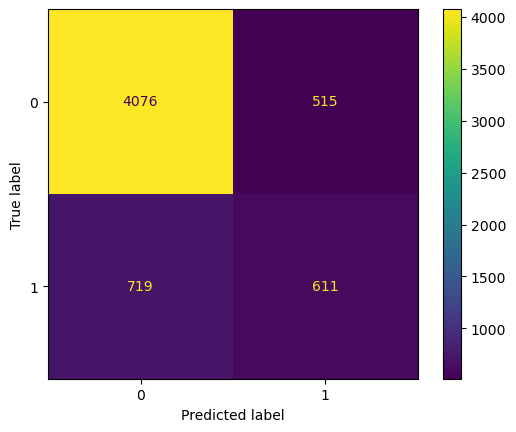

In [49]:
cm = confusion_matrix(y_test, y_pred_rf, labels=randomforest_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=randomforest_estimator.classes_)
disp.plot()
plt.show()

### 2. XGBoost

In [51]:
grid_param = {'n_estimators':[100, 200]}

In [52]:
xgb_estimator = XGBClassifier(booster = "gbtree", random_state = 42, n_jobs=4)

scorer = make_scorer(recall_score, pos_label = 1)

cv_xgboost = GridSearchCV(estimator=xgb_estimator, 
                        param_grid=grid_param, 
                        scoring = scorer, 
                        cv = 10)

cv_xgboost = cv_xgboost.fit(X_train_smote, y_train_smote)

xgb_estimator = cv_xgboost.best_estimator_

xgb_estimator.fit(X_train_smote, y_train_smote)

y_pred_xg = xgb_estimator.predict(X_test)
evaluate_report(y_test,y_pred_xg)

Accuracy: 79.68%
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      4591
           1       0.57      0.37      0.45      1330

    accuracy                           0.80      5921
   macro avg       0.70      0.65      0.66      5921
weighted avg       0.78      0.80      0.78      5921



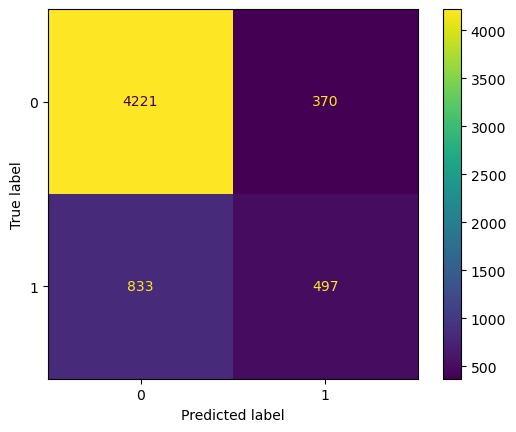

In [53]:
cm = confusion_matrix(y_test, y_pred_xg, labels=xgb_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_estimator.classes_)
disp.plot()
plt.show()

### 3. Support Vactor Machine (SVM)

In [22]:
grid_param = {
      'C': [0.1],
      'kernel': ['poly'],
      'gamma': [0.01]
    }
    
svc_estimator=SVC(probability=True)

scorer = make_scorer(recall_score, pos_label = 1)

cv_svc = GridSearchCV(estimator=svc_estimator, 
                        param_grid=grid_param,
                        verbose = 5,
                        scoring = scorer,
                        cv = 2)

svc_grid = cv_svc.fit(X_train_smote, y_train_smote)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END ....C=0.1, gamma=0.01, kernel=poly;, score=0.247 total time= 3.0min
[CV 2/2] END ....C=0.1, gamma=0.01, kernel=poly;, score=0.225 total time= 2.6min


In [23]:
svc_grid.best_estimator_

SVC(C=0.1, gamma=0.01, kernel='poly', probability=True)

In [24]:
svc_estimator = svc_grid.best_estimator_

svc_estimator.fit(X_train_smote, y_train_smote)

y_pred_svc = svc_estimator.predict(X_test)

In [27]:
evaluate_report(y_test,y_pred_svc)

Accuracy: 79.78%
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      4591
           1       0.64      0.23      0.34      1330

    accuracy                           0.80      5921
   macro avg       0.72      0.60      0.61      5921
weighted avg       0.77      0.80      0.76      5921



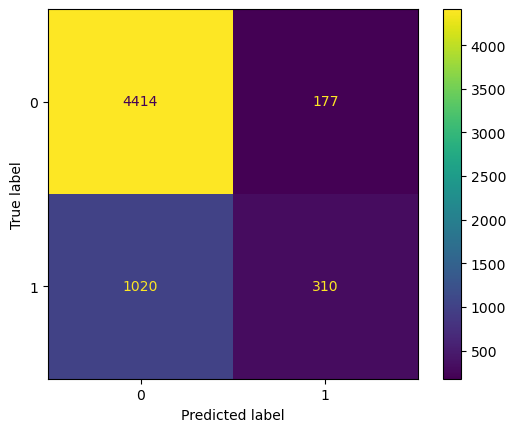

In [28]:
cm = confusion_matrix(y_test, y_pred_svc, labels=svc_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_estimator.classes_)
disp.plot()
plt.show()

### 4.Logistic Regression

In [29]:
grid_param = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
    

lr_estimator=LogisticRegression()

scorer = make_scorer(recall_score, pos_label = 1)

grid = GridSearchCV(estimator=lr_estimator, 
                        param_grid=grid_param, 
                        verbose = 5,
                        scoring = scorer,
                        cv = 5)

lr_grid = grid.fit(X_train_smote, y_train_smote)

lr_estimator = lr_grid.best_estimator_

lr_estimator.fit(X_train_smote, y_train_smote)

y_pred_lr = lr_estimator.predict(X_test)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END ...............C=0.001, penalty=l2;, score=0.625 total time=   0.2s
[CV 2/5] END ...............C=0.001, penalty=l2;, score=0.638 total time=   0.1s
[CV 3/5] END ...............C=0.001, penalty=l2;, score=0.646 total time=   0.1s
[CV 4/5] END ...............C=0.001, penalty=l2;, score=0.644 total time=   0.1s
[CV 5/5] END ...............C=0.001, penalty=l2;, score=0.650 total time=   0.2s
[CV 1/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ..................C=0.01, penalty=l

/Users/shikhagautam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .................C=1.0, penalty=l2;, score=0.618 total time=   0.4s


/Users/shikhagautam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .................C=1.0, penalty=l2;, score=0.642 total time=   0.4s
[CV 3/5] END .................C=1.0, penalty=l2;, score=0.653 total time=   0.4s
[CV 4/5] END .................C=1.0, penalty=l2;, score=0.671 total time=   0.6s
[CV 5/5] END .................C=1.0, penalty=l2;, score=0.655 total time=   0.4s
[CV 1/5] END ..................C=10.0, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ..................C=10.0, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ..................C=10.0, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ..................C=10.0, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ..................C=10.0, penalty=l1;, score=nan total time=   0.0s


/Users/shikhagautam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ................C=10.0, penalty=l2;, score=0.618 total time=   0.7s


/Users/shikhagautam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ................C=10.0, penalty=l2;, score=0.643 total time=   0.8s


/Users/shikhagautam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ................C=10.0, penalty=l2;, score=0.653 total time=   0.4s


/Users/shikhagautam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ................C=10.0, penalty=l2;, score=0.671 total time=   0.4s
[CV 5/5] END ................C=10.0, penalty=l2;, score=0.655 total time=   1.3s
[CV 1/5] END .................C=100.0, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END .................C=100.0, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END .................C=100.0, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END .................C=100.0, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END .................C=100.0, penalty=l1;, score=nan total time=   0.0s


/Users/shikhagautam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...............C=100.0, penalty=l2;, score=0.618 total time=   1.0s


/Users/shikhagautam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...............C=100.0, penalty=l2;, score=0.644 total time=   0.6s


/Users/shikhagautam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...............C=100.0, penalty=l2;, score=0.653 total time=   1.3s


/Users/shikhagautam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...............C=100.0, penalty=l2;, score=0.671 total time=   1.0s
[CV 5/5] END ...............C=100.0, penalty=l2;, score=0.655 total time=   1.2s
[CV 1/5] END ................C=1000.0, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ................C=1000.0, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ................C=1000.0, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ................C=1000.0, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ................C=1000.0, penalty=l1;, score=nan total time=   0.0s


/Users/shikhagautam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..............C=1000.0, penalty=l2;, score=0.618 total time=   1.3s


/Users/shikhagautam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..............C=1000.0, penalty=l2;, score=0.643 total time=   0.6s


/Users/shikhagautam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..............C=1000.0, penalty=l2;, score=0.653 total time=   0.6s


/Users/shikhagautam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..............C=1000.0, penalty=l2;, score=0.671 total time=   0.4s
[CV 5/5] END ..............C=1000.0, penalty=l2;, score=0.655 total time=   0.4s


/Users/shikhagautam/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/shikhagautam/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shikhagautam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shikhagautam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linea

In [30]:
evaluate_report(y_test,y_pred_lr)

Accuracy: 67.71%
              precision    recall  f1-score   support

           0       0.86      0.70      0.77      4591
           1       0.37      0.61      0.46      1330

    accuracy                           0.68      5921
   macro avg       0.61      0.65      0.61      5921
weighted avg       0.75      0.68      0.70      5921



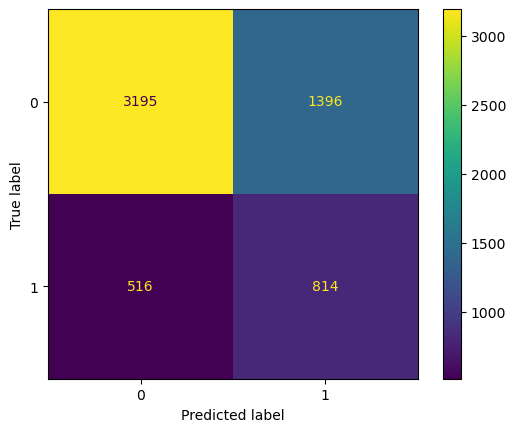

In [31]:
cm = confusion_matrix(y_test, y_pred_lr, labels=lr_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_estimator.classes_)
disp.plot()
plt.show()

## Feature Importance

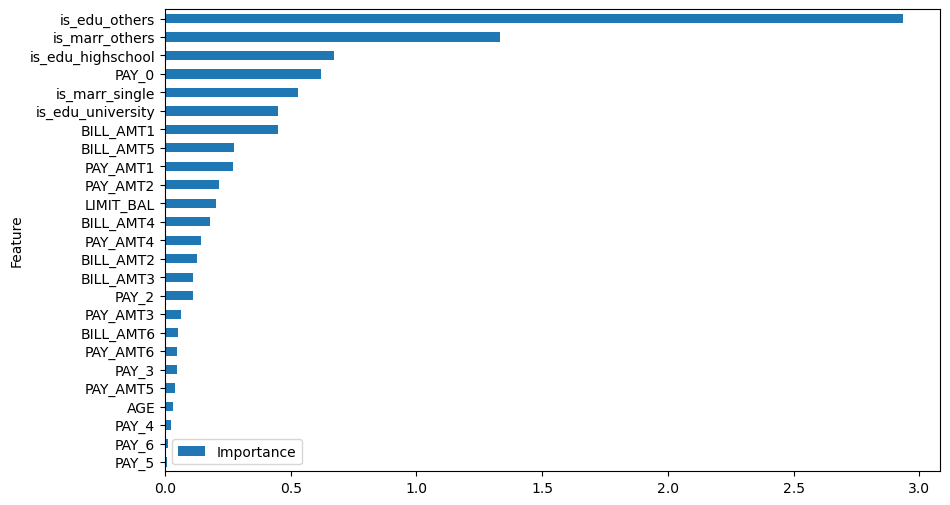

In [59]:
coefficients = lr_estimator.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train_smote.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

### 5.Neural Network 

In [32]:
target = y_train_smote
dataset= tf.convert_to_tensor(X_train_smote)

In [33]:
model = Sequential()

model.add(
        Dense(19, activation='relu')
)

model.add(
        Dense(10, activation='relu')
)

model.add(
        Dense(5, activation='relu')
)


model.add(
        Dense(1, activation='sigmoid')
)

model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy']
)

early_stop = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        verbose=1, 
        patience=25
)

model.fit(
        X_train_smote, 
        y_train_smote, 
        epochs=200, 
        batch_size=256, 
        validation_data=(X_test, y_test),
         callbacks=[early_stop])

Epoch 1/200
144/144 [==============================] - 2s 5ms/step - loss: 0.6270 - accuracy: 0.6377 - val_loss: 0.6161 - val_accuracy: 0.7774
Epoch 2/200
144/144 [==============================] - 0s 3ms/step - loss: 0.5814 - accuracy: 0.7012 - val_loss: 0.6001 - val_accuracy: 0.7651
Epoch 3/200
144/144 [==============================] - 0s 3ms/step - loss: 0.5676 - accuracy: 0.7049 - val_loss: 0.5741 - val_accuracy: 0.7649
Epoch 4/200
144/144 [==============================] - 1s 4ms/step - loss: 0.5597 - accuracy: 0.7084 - val_loss: 0.5791 - val_accuracy: 0.7570
Epoch 5/200
144/144 [==============================] - 0s 3ms/step - loss: 0.5550 - accuracy: 0.7133 - val_loss: 0.5655 - val_accuracy: 0.7541
Epoch 6/200
144/144 [==============================] - 1s 6ms/step - loss: 0.5520 - accuracy: 0.7141 - val_loss: 0.5634 - val_accuracy: 0.7519
Epoch 7/200
144/144 [==============================] - 1s 7ms/step - loss: 0.5499 - accuracy: 0.7167 - val_loss: 0.5710 - val_accuracy: 0.7497

<AxesSubplot:>

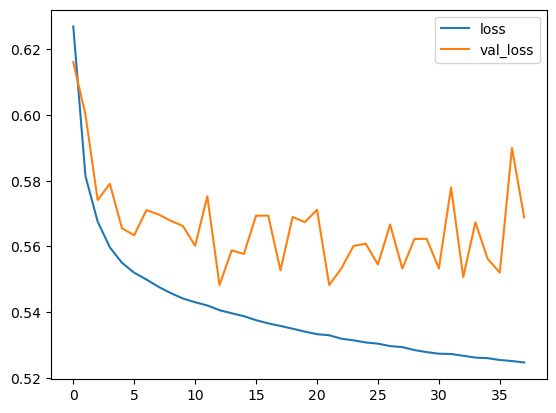

In [35]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()

In [36]:
test_predictions = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test,test_predictions))

186/186 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      4591
           1       0.44      0.62      0.51      1330

    accuracy                           0.74      5921
   macro avg       0.66      0.69      0.67      5921
weighted avg       0.78      0.74      0.75      5921



In [37]:
tf.math.confusion_matrix(y_test,test_predictions)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[3546, 1045],
       [ 512,  818]], dtype=int32)>

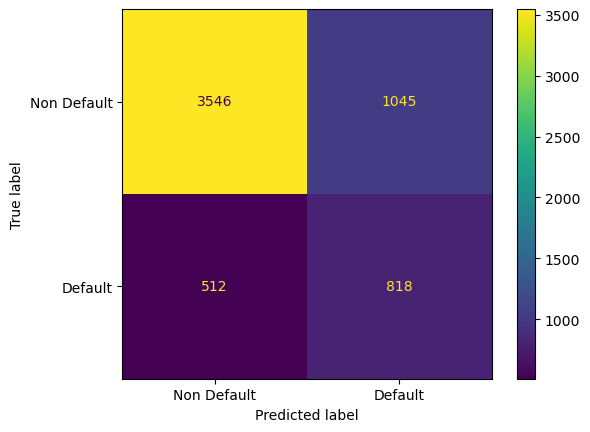

In [38]:
cm = confusion_matrix(y_test, test_predictions, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non Default','Default'])
disp.plot()
plt.show()

In [40]:
from collections import Counter
Counter(test_predictions.reshape(1,-1)[0])

Counter({1: 1863, 0: 4058})

### Models Analysis- 

Before analysing model performance or metrics we wanted to make sure that we are focusing on 
recall score of each model. 

Because recall is a performance metric which attempts to answer the question: which is 

What proportion of actual positives (defaulters) was identified correctly?


                            Recall = TP(True Positive)/ TP+FN(False Negative)
                         
TP = True Positive, or a correctly predicted default
FN = False Negative, or an incorrectly predicted non-default


Ideally, we do not want to allow any defaulters to misclassified.


So our optimal model will minimize False Negatives (So RecallScore is as high as possible)


As we can see here that we used all models each with GridSearchCv and also use last model (Neural Network) 
with 3 hidden layers and we can find that Logistic Regression and Neural network performs well on recall score 
with 0.61 and 0.62 respectively.    

### ROC-Curve(AUC)

186/186 [==============================] - 0s 1ms/step


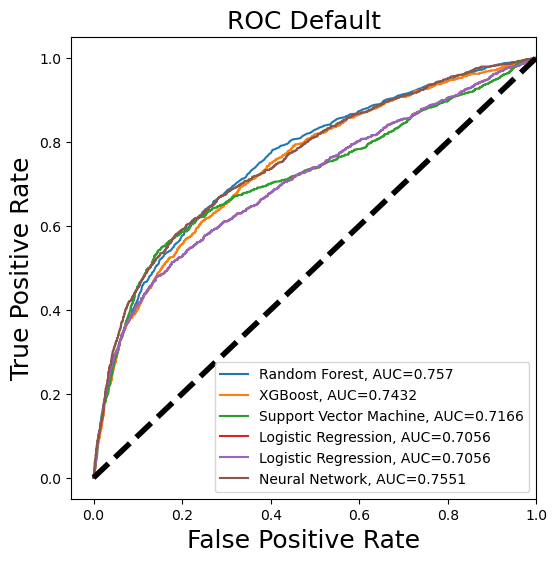

In [54]:
plt.figure(figsize=[6,6])

y_pred_rf = randomforest_estimator.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_rf )
auc = round(metrics.roc_auc_score(y_test, y_pred_rf), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))


y_pred_xg = xgb_estimator.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_xg )
auc = round(metrics.roc_auc_score(y_test, y_pred_xg), 4)
plt.plot(fpr,tpr,label="XGBoost, AUC="+str(auc))

y_pred_svc = svc_estimator.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_svc )
auc = round(metrics.roc_auc_score(y_test, y_pred_svc), 4)
plt.plot(fpr,tpr,label="Support Vector Machine, AUC="+str(auc))

y_pred_lr =lr_estimator.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_lr)
auc = round(metrics.roc_auc_score(y_test, y_pred_lr), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))


y_pred_lr =lr_estimator.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_lr)
auc = round(metrics.roc_auc_score(y_test, y_pred_lr), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

y_pred_keras = model.predict(X_test).ravel()
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_keras)
auc=round(metrics.roc_auc_score(y_test, y_pred_keras), 4)
plt.plot(fpr,tpr,label="Neural Network, AUC="+str(auc))

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Default', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Conclusion-

As we can see all models recall score so Neural Network is the clear winner here with the recall score 0.62 
followed by logistic regression. 


If we can talk about Area under the curve score then Random Forest performed well.

So, finally if we have to give recommendation on same kind of dataset we can say that by using neural network
and may be do some more fine tuning in it model can predict 62% correct deafulters. 

Finally, we can say by doing all the anlaysis that our winner model (Neural Network) save 
approx Taiwan $40 M  cost by finding defaulters right.